# Messungen an Objekten in gekachelten Bildern
Für einige spezifische Bildanalyseaufgaben könnte es möglich sein, Einschränkungen zu überwinden, wie sie bei der Anwendung der verbundenen Komponentenmarkierung auftreten. 

Zum Beispiel, wenn die Größe von Objekten gemessen wird und diese Objekte in ihrer Größe begrenzt sind, ist es nicht notwendig, Zwischenergebnisse der Bildverarbeitung in großen Bildern zu kombinieren.
Wir könnten einfach Objekteigenschaften für alle Objekte in Kacheln messen und dann das Ergebnis der Quantifizierung kombinieren.

In [1]:
import numpy as np
import dask
import dask.array as da
from skimage.data import cells3d
from skimage.io import imread
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow

Unser Ausgangspunkt ist wieder ein Binärbild, das segmentierte Objekte zeigt.

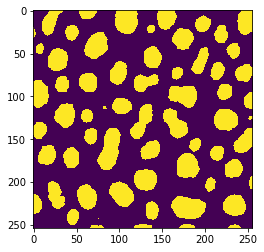

In [2]:
image = imread("../../data/blobs.tif") > 128
imshow(image)

Diesmal möchten wir die Größe der Objekte messen und das in einem parametrischen Bild visualisieren. Zu Demonstrationszwecken führen wir diese Operation zuerst am gesamten Beispielbild aus.

In [3]:
def area_map(image):
    """
    Label objects in a binary image and produce a pixel-count-map image.
    """
    labels = cle.connected_components_labeling_box(image)
    result = cle.pixel_count_map(labels)
    
    return np.asarray(result)
    

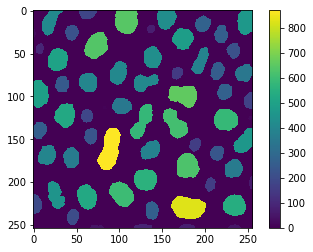

In [4]:
reference = area_map(image)

cle.imshow(reference, colorbar=True)

Wenn wir dasselbe in Kacheln verarbeiten, erhalten wir leicht falsche Ergebnisse aufgrund des zuvor demonstrierten Problems mit der gekachelten Verbindungskomponentenmarkierung.

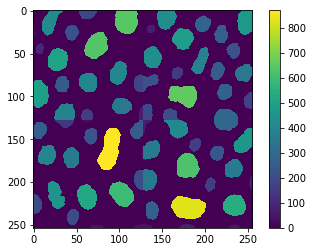

In [5]:
# tile the image
tiles = da.from_array(image, chunks=(128, 128))

# setup the operation we want to apply
procedure = area_map

# setup the tiling
tile_map = da.map_blocks(procedure, tiles)

# compute result
result = tile_map.compute()

# visualize
imshow(result, colorbar=True)

Wieder sind die Fehler am Rand sichtbar und wir können das durch direkten Vergleich visualisieren:

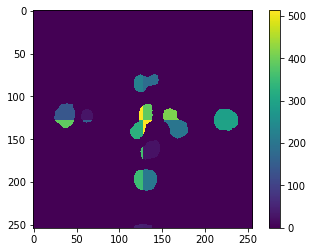

In [6]:
absolute_error = cle.absolute_difference(result, reference)

cle.imshow(absolute_error, colorbar=True)

Um diesen Fehler zu verhindern, müssen wir erneut darüber nachdenken, die Bildkacheln mit einer Überlappung zu verarbeiten. In diesem speziellen Beispiel führen wir keine Operation aus, die benachbarte Pixel berücksichtigt. Daher können wir die notwendige Überlappung nicht aus solchen Parametern abschätzen. Wir müssen die maximale Größe (Durchmesser) der Objekte berücksichtigen. Wir könnten dies auch empirisch tun, wie zuvor. Lassen Sie uns daher zunächst den mittleren quadratischen Fehler der beiden obigen Beispielergebnisse berechnen:

In [7]:
cle.mean_squared_error(result, reference)

4338.783956692913

Als Nächstes können wir diesen Fehler in einer Schleife berechnen, wobei wir die Überlappung mit [dask.array.map_overlay](https://docs.dask.org/en/stable/array-overlap.html) variieren, während wir das Bild in Kacheln verarbeiten. Beachten Sie, dass wir hier `boundary=0` setzen, da sich sonst die Objekte im Binärbild ausdehnen und die Größenmessungen falsch wären.

In [8]:
for overlap_width in range(0, 30, 5):
    print("Overlap width", overlap_width)
    tile_map = da.map_overlap(procedure, tiles, depth=overlap_width, boundary=0)
    result = tile_map.compute()
    print("mean squared error", cle.mean_squared_error(result, reference))
    print("-----------------------------------")

Overlap width 0
mean squared error 4338.783956692913
-----------------------------------
Overlap width 5
mean squared error 1702.8293553149606
-----------------------------------
Overlap width 10
mean squared error 460.85811392716533
-----------------------------------
Overlap width 15
mean squared error 70.78670952263779
-----------------------------------
Overlap width 20
mean squared error 1.2793891486220472
-----------------------------------
Overlap width 25
mean squared error 0.0
-----------------------------------


Die empirisch ermittelte Überlappung, bei der dieser Fehler 0 wird, ist eine optimistische Schätzung. Wenn Sie diese Methode in Ihrem Beispiel verwenden, stellen Sie sicher, dass Sie eine Überlappung anwenden, die größer als der ermittelte Wert ist. 

**Hinweis:** Die Funktionen `compute` und `imshow` funktionieren möglicherweise nicht bei großen Datensätzen, da die Bilder möglicherweise nicht in den Arbeitsspeicher des Computers passen. Wir verwenden sie hier zu Demonstrationszwecken.

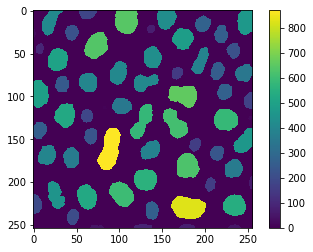

In [9]:
overlap_width = 30

tile_map = da.map_overlap(procedure, tiles, depth=overlap_width, boundary=0)
result = tile_map.compute()

cle.imshow(tile_map, colorbar=True)